<a href="https://colab.research.google.com/github/nina-adhikari/enjoyment-maximizing-maps/blob/main/mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# packages that need to be installed
!pip install mapclassify # Choropleth map classification; basically for Geopandas

In [2]:
# packages that need to be loaded
import matplotlib.pyplot as plt #for the pandas profiling
import geopandas as gpd #extends the datatypes used by pandas to allow spatial operations on geometric types
import pandas as pd
import numpy as np
import pickle

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay

# 1. Importing and cleaning data

In [11]:
# global variables to be defined
DIR = 'drive/MyDrive/walkability/'   # directory where all files are stored
HEALTH_OUTCOME = 'LPA'
SEED = 47
rng = np.random.default_rng(SEED)

In [ ]:
# datasets stored in drive/MyDrive/walkability/
health = DIR + 'health.csv'      # 500 Cities: Local Data for Better Health https://data.cdc.gov/500-Cities-Places/500-Cities-Local-Data-for-Better-Health-2019-relea/6vp6-wxuq/about_data
epacsv = DIR + 'epdownload.csv'  # Smart Location Database https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv
income = DIR + 'income.csv'      # Median household income https://data.census.gov/table/ACSDT5Y2017.B19013?q=b19013&g=040XX00US11$1400000&moe=false&tp=true
walk_gdb = DIR + 'walk_index.gdb'

In [ ]:
# allow colab to access your Google Drive, an authentication window will pop-up
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Import the Income dataset:

In [4]:
inc = gpd.read_file(income).drop('geometry', axis=1)                            # converts GeoDataFrame to a normal DataFrame by dropping the geometry column?
inc['Income'] = inc['Income'].str.replace(',','')                               # replace comma format for numbers
inc = inc.apply(pd.to_numeric, errors='coerce')                                 # convert to numeric, coerce makes invalid parsing be set as NaN
inc['Tract'] = round(inc['Tract'].astype(float)*100).astype(int)                # format census tract id as integer
inc.set_index('Tract', inplace=True)                                            # tract id is the index of this dataframe

Import the SLD dataset:

In [5]:
columns_to_drop = ['GEOID20', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'CBSA_POP', 'CBSA_EMP', 'CBSA_WRK']
epa_init = gpd.read_file(epacsv, where="STATEFP='11'").drop(columns=columns_to_drop)   # only interested in DC

# GEO ID data is corrupted in csv because it was stored as a float, so we generate it using other data and padding
epa_init['GEOID10'] = epa_init['STATEFP'].str.zfill(2) + epa_init['COUNTYFP'].str.zfill(3) + epa_init['TRACTCE'].str.zfill(6) + epa_init['BLKGRPCE']

epa_init['TRACTCE'] = epa_init['TRACTCE'].astype(int)                           # format as integer to use for merging later
epa_init.set_index('OBJECTID', inplace=True)

Since the CSV doesn't have geometry data for plotting, we import it from another file (which comes from the same EPA dataset):

In [ ]:
gdb = gpd.read_file(walk_gdb, where="STATEFP='11'")[['GEOID10', 'geometry']]
gdb['GEOID10'] = gdb['GEOID10'].astype(int)
gdb.set_index('GEOID10', inplace=True)
epa_init['GEOID10'] = epa_init['GEOID10'].astype(int)
epa = epa_init.join(other=gdb, on='GEOID10', how='left', validate='1:1', lsuffix='epa')
epa.drop(columns=['geometryepa'], inplace=True)
epa

Import the health dataset:

In [7]:
hl = gpd.read_file(health, where="StateAbbr='DC' AND GeographicLevel='Census Tract'", include_fields=['StateAbbr', 'GeographicLevel', 'UniqueID', 'MeasureId', 'CityFIPS', 'TractFIPS', 'Data_Value'])
hl['TractCE'] = hl['TractFIPS'].str.removeprefix('110010').astype(int)          # format index column
hlp = hl.pivot(index='TractCE', columns='MeasureId', values='Data_Value')       # pivot table to have the columns be the MeasureId

Merge all datasets:

In [8]:
firstjoin = epa.join(other=inc, on='TRACTCE', how='left', validate='m:1')                   # merge EPA and income data
secondjoin = firstjoin.join(other=hlp[HEALTH_OUTCOME], on='TRACTCE', how='left', validate='m:1')     # merge above with CDC data
secondjoin = secondjoin.apply(pd.to_numeric, errors='ignore')
secondjoin

GEOID10  STATEFP  COUNTYFP  TRACTCE  BLKGRPCE    Ac_Total  \
OBJECTID                                                                   
61344     110010040023       11         1     4002         3   16.948095   
61345     110010041001       11         1     4100         1   25.638849   
61346     110010042022       11         1     4202         2   23.832548   
61347     110010053014       11         1     5301         4   16.884343   
61348     110010050021       11         1     5002         1    9.810858   
...                ...      ...       ...      ...       ...         ...   
61789     110010007022       11         1      702         2   18.081790   
61790     110010007012       11         1      701         2   19.805559   
61791     110010013023       11         1     1302         3  125.755120   
61792     110010055004       11         1     5500         4   12.317935   
61793     110010055005       11         1     5500         5   11.278138   

          Ac_Water     Ac_Land     Ac_Unpr  TotPop  ...  D2A_Ranked  \
OBJECTID                                            ...               
61344     0.000000   16.948095   16.948095     553  ...          17   
61345     0.000000   25.638849   24.554800    1210  ...          13   
61346     0.000000   23.832548   23.832548    1188  ...          17   
61347     0.000000   16.884343   16.884343    1150  ...          16   
61348     0.000000    9.810858    9.810858    1739  ...           4   
...            ...         ...         ...     ...  ...         ...   
61789     0.000000   18.081790   18.081790    1045  ...           2   
61790     0.000000   19.805559   18.978260    1080  ...           3   
61791     1.303205  124.451915  108.547510     573  ...          15   
61792     0.000000   12.317935   12.317935     840  ...          16   
61793     0.000000   11.278138   11.278138     794  ...          11   

          D2B_Ranked  D3B_Ranked  D4A_Ranked  NatWalkInd  Shape_Length  \
OBJECTID                                                                 
61344             10          19          19   17.166667   1201.674704   
61345             16          20          19   17.833333   1328.833340   
61346             12          20          18   17.500000   1450.239008   
61347             16          12          19   15.666667   1158.771615   
61348              5          16          19   13.166667    801.162123   
...              ...         ...         ...         ...           ...   
61789              8          13          19   12.333333   1338.001954   
61790              7          12          19   12.000000   1175.108163   
61791             10          10          17   13.166667   4543.930515   
61792              8          18          19   16.333333    908.923000   
61793              5          20          20   16.000000    883.428872   

            Shape_Area                                           geometry  \
OBJECTID                                                                    
61344      68587.96738  MULTIPOLYGON (((1617361.678 1927352.465, 16173...   
61345     103759.02510  MULTIPOLYGON (((1617028.696 1927124.163, 16170...   
61346      96448.75188  MULTIPOLYGON (((1617427.574 1927158.696, 16174...   
61347      68329.30242  MULTIPOLYGON (((1617857.365 1926906.416, 16178...   
61348      39703.77108  MULTIPOLYGON (((1618967.176 1926639.840, 16189...   
...                ...                                                ...   
61789      73175.60627  MULTIPOLYGON (((1614569.609 1927830.272, 16146...   
61790      80152.05213  MULTIPOLYGON (((1614183.231 1928298.295, 16141...   
61791     508923.40880  MULTIPOLYGON (((1615366.380 1930018.785, 16153...   
61792      49850.70702  MULTIPOLYGON (((1617341.161 1926369.481, 16173...   
61793      45641.83728  MULTIPOLYGON (((1617519.949 1926422.883, 16175...   

            Income   LPA  
OBJECTID                  
61344     102455.0  12.6  
61345     143586.0  14.3  
61346     105978.0  12.7  
61

Further cleaning:

In [15]:
# Some of the entries are set to -99999 (see the PDF, page 23 footnote 65), so we will replace them (and in fact all negative entries) with NaN:
secondjoin[secondjoin.drop(columns=['geometry']) < 0] = np.nan

# Drop the rows that have NaNs
df_full = secondjoin.dropna()

# Columns we ignore when doing numerical operations
non_numeric_columns = ['GEOID10', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'Shape_Length', 'Shape_Area', 'geometry']

df_geo = df_full['geometry']                                                             # The GeoDataFrame that has mapping info
df_presplit = df_full.drop(columns=non_numeric_columns)                                  # The purely numeric dataframe that we will use for regressions

We make a train-test split here, and will not touch the test data until final model evaluation.

In [19]:
df, df_test, outcome, outcome_test = train_test_split(df_presplit, df_presplit[HEALTH_OUTCOME], test_size=0.2, random_state=SEED)

In [108]:
# open dictionary that contains the explanation of each column name
picklefile = DIR + 'cols_dict.pickle'
with open(picklefile, 'rb') as handle:
    cols_dict = pickle.load(handle)

In [109]:
cols_dict

{'GEOID10': 'Census block group 12-digit FIPS code (2010)',
 'GEOID20': 'Census block group 12-digit FIPS code (2018)',
 'STATEFP': 'State FIPS code',
 'COUNTYFP': 'County FIPS cod',
 'TRACTCE': 'Census tract FIPS code in which CBG resides',
 'BLKGRPCE': 'Census block group FIPS code in which CBG resides',
 'CSA': 'Combined Statistical Area (CSA) Code',
 'CSA_Name': 'Name of CSA in which CBG resides',
 'CBSA': 'FIPS for Core-Based Statistical Area (CBSA) in which\nCBG resides',
 'CBSA_Name': 'Name of CBSA in which CBG resides',
 'CBSA_POP': 'Total population in CBSA',
 'CBSA_EMP': 'Total employment in CBSA',
 'CBSA_WRK': 'Total number of workers that live in CBSA',
 'Ac_Total': 'Total geometric area (acres) of the CBG',
 'Ac_Water': 'Total water area (acres)',
 'Ac_Land': 'Total land area (acres)',
 'Ac_Unpr': 'Total land area (acres) that is not protected from\ndevelopment (i.e., not a park, natural area or conservation\narea)',
 'TotPop': 'Population, 2018',
 'CountHU': 'Housing unit

# 2. Feature selection

## a. Lasso

Set up some basic settings:

In [20]:
features = list(df.drop(columns=[HEALTH_OUTCOME]).columns)

## These are the features that need to be scaled
scale_columns = range(len(features))

ITERS = 5

#lasso hyperparameter
ALPHAS = [.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000] #15

In [21]:
MAX_ITERATIONS = 1000000
TOLERANCE = 0.001

def lasso_for_one_dataset(dataset, outcomes):
  #initialize min_idx array
  min_idx = np.zeros(len(features))

  ## make coefficient holder
  coefs = np.zeros((len(ALPHAS), len(features)))

  ## Loop through alphas
  for i in range(len(ALPHAS)):
    ## make lasso model
    lasso = Lasso(alpha=ALPHAS[i], max_iter=MAX_ITERATIONS, tol=TOLERANCE, fit_intercept=False)

    ## fit model
    lasso.fit(dataset, outcomes)

    ## record coefs
    coefs[i,:] = lasso.coef_
    coef_df = pd.DataFrame(data=coefs, index=ALPHAS, columns=features)
    prev_min_idx = min_idx
    min_idx = coef_df.ne(0).idxmin().values

    if (min_idx == prev_min_idx).all():
      break
  return min_idx

In [22]:
# We want to do the randomization multiple times
min_idx = np.zeros((len(features), ITERS))

# Get some random states
states = rng.integers(low=10, high=70, size=5)

for i in range(ITERS):
  ## make a train test split here
  df_copy = df.copy()
  urban_train, urban_test = train_test_split(
    df_copy,
    shuffle = True,
    random_state = states[i],
    test_size = .8
    )
  ## scale quantitative variables
  urban_train_array = urban_train[features].to_numpy()
  scaler = StandardScaler()

  urban_train_array_scaled = urban_train_array.copy()
  urban_train_array_scaled[:,scale_columns] = scaler.fit_transform(urban_train_array_scaled[:,scale_columns])

  min_idx[:,i] = lasso_for_one_dataset(urban_train_array_scaled, urban_train[HEALTH_OUTCOME].values)

min_idx_df = pd.DataFrame(data=min_idx, index=features, columns=range(ITERS))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.860e+02, tolerance: 5.059e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e+02, tolerance: 5.437e+01
  model = cd_fast.enet_coordinate_descent(


In [23]:
#add a score col and sort
min_idx_df['score'] = np.round(min_idx_df.sum(axis=1, numeric_only=True), 1)
misorted = min_idx_df.sort_values(by=['score'], ascending=False)
misorted

0        1        2        3        4  score
R_PCTLOWWAGE  10.0000  10.0000  10.0000  10.0000  10.0000   50.0
Income        10.0000   5.0000  10.0000  10.0000  10.0000   45.0
R_MedWageWk    5.0000   1.0000   5.0000   5.0000   5.0000   21.0
D5BR           5.0000   0.0100   0.0010   5.0000   0.1000   10.1
D5AR           0.1000   0.2500   0.2500   5.0000   0.5000    6.1
...               ...      ...      ...      ...      ...    ...
D1C5_OFF       0.0001   0.0001   0.0010   0.0100   0.0001    0.0
D1C8_OFF       0.0010   0.0100   0.0100   0.0001   0.0100    0.0
D1D            0.0001   0.0001   0.0001   0.0001   0.0001    0.0
D1_FLAG        0.0001   0.0001   0.0001   0.0001   0.0001    0.0
Ac_Total       0.0001   0.0010   0.0001   0.0010   0.0001    0.0

[102 rows x 6 columns]

Only keep features above a certain threshold:

In [33]:
THRESHOLD = 0.0

features_of_interest = set(misorted.loc[misorted['score'] > THRESHOLD].index)
#df_reg = df.copy()[features_of_interest]

#scaler = StandardScaler().set_output(transform="pandas")
#df_reg = scaler.fit_transform(df_reg)
#df_reg[HEALTH_OUTCOME] = df[HEALTH_OUTCOME]
#df_reg

## b. Profiling

In [ ]:
!pip install ydata-profiling # Data profiling and exploratory data analysis
from ydata_profiling import ProfileReport #automatic profiling of datasets

In [26]:
report = ProfileReport(df, minimal=True)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The analysis above shows there are many columns with lots of zeroes. We will drop those features that have zeroes above a certain threshold:

In [36]:
ZERO_THRESHOLD = 0.3

zeroes = df.isin([0]).sum(axis=0) / len(df)
zeroes
columns_with_zeroes = [x for x in zeroes.axes[0] if zeroes[x] > ZERO_THRESHOLD]
features_of_interest = features_of_interest.difference(columns_with_zeroes)
features_of_interest

{'Ac_Land',
 'Ac_Unpr',
 'AutoOwn0',
 'AutoOwn1',
 'AutoOwn2p',
 'CountHU',
 'D1A',
 'D1B',
 'D1C5_SVC',
 'D1C8_HLTH',
 'D1C8_SVC',
 'D2A_EPHHM',
 'D2A_JPHH',
 'D2A_Ranked',
 'D2A_WRKEMP',
 'D2B_E5MIX',
 'D2B_E5MIXA',
 'D2B_E8MIX',
 'D2B_E8MIXA',
 'D2B_Ranked',
 'D2C_TRIPEQ',
 'D2C_TRPMX1',
 'D2C_WREMLX',
 'D2R_JOBPOP',
 'D2R_WRKEMP',
 'D3A',
 'D3AMM',
 'D3APO',
 'D3BMM3',
 'D3BMM4',
 'D3BPO3',
 'D3BPO4',
 'D3B_Ranked',
 'D4A',
 'D4A_Ranked',
 'D4C',
 'D4D',
 'D4E',
 'D5AE',
 'D5AR',
 'D5BE',
 'D5BR',
 'D5CE',
 'D5CEI',
 'D5CR',
 'D5DE',
 'D5DR',
 'E5_Off',
 'E8_Hlth',
 'E_LowWageWk',
 'E_MedWageWk',
 'E_PctLowWage',
 'Income',
 'P_WrkAge',
 'Pct_AO1',
 'Pct_AO2p',
 'R_HiWageWk',
 'R_LowWageWk',
 'R_MedWageWk',
 'R_PCTLOWWAGE',
 'TotPop'}

## c. Checking correlations

In [27]:
cols_dict

{'GEOID10': 'Census block group 12-digit FIPS code (2010)',
 'GEOID20': 'Census block group 12-digit FIPS code (2018)',
 'STATEFP': 'State FIPS code',
 'COUNTYFP': 'County FIPS cod',
 'TRACTCE': 'Census tract FIPS code in which CBG resides',
 'BLKGRPCE': 'Census block group FIPS code in which CBG resides',
 'CSA': 'Combined Statistical Area (CSA) Code',
 'CSA_Name': 'Name of CSA in which CBG resides',
 'CBSA': 'FIPS for Core-Based Statistical Area (CBSA) in which\nCBG resides',
 'CBSA_Name': 'Name of CBSA in which CBG resides',
 'CBSA_POP': 'Total population in CBSA',
 'CBSA_EMP': 'Total employment in CBSA',
 'CBSA_WRK': 'Total number of workers that live in CBSA',
 'Ac_Total': 'Total geometric area (acres) of the CBG',
 'Ac_Water': 'Total water area (acres)',
 'Ac_Land': 'Total land area (acres)',
 'Ac_Unpr': 'Total land area (acres) that is not protected from\ndevelopment (i.e., not a park, natural area or conservation\narea)',
 'TotPop': 'Population, 2018',
 'CountHU': 'Housing unit

We find all pairs of features correlated above a certain threshold:

In [55]:
CORRELATION_THRESHOLD = 0.8

corr = df[list(features_of_interest)].corr()
corr.values[np.triu_indices_from(corr, 0)] = np.nan
corr_series = corr.abs().unstack()
corr_series[corr_series > CORRELATION_THRESHOLD][corr_series < 1]

D4E          D4C            0.807668
D4A_Ranked   D4A            0.944076
D5BE         D5DR           0.916079
             D5BR           0.916079
             D5DE           1.000000
R_LowWageWk  R_MedWageWk    0.915528
D5CR         D5AR           1.000000
Ac_Land      Ac_Unpr        0.878317
D2A_Ranked   D2A_EPHHM      0.990675
             D2C_TRPMX1     0.812465
D2B_E5MIXA   D2B_E8MIXA     0.847690
             D2B_E5MIX      0.871574
             D2B_Ranked     0.826897
D5DR         D5BR           1.000000
             D5DE           0.916079
D2B_E8MIXA   D2B_E8MIX      0.807375
             D2B_Ranked     0.957823
D2A_EPHHM    D2C_TRPMX1     0.832853
D2R_JOBPOP   D2C_WREMLX     0.837807
D5AE         D5CE           1.000000
CountHU      AutoOwn0       0.810892
             AutoOwn1       0.869074
D2A_JPHH     D1C5_SVC       0.837438
             E_LowWageWk    0.905526
             E_MedWageWk    0.889959
E5_Off       E_MedWageWk    0.823451
D1C8_SVC     D1C5_SVC       0.959255
D

Based on the above data as well as our understanding of the features and their redundancies, we drop the following features:

In [73]:
correlated_features = ['D4C', 'D4A_Ranked', 'D5AE', 'D5AR', 'D5BR', 'D5BE', 'D5CEI', 'D5DE', 'Ac_Unpr',
                       'D2A_Ranked', 'D2B_Ranked', 'CountHU', 'E_LowWageWk', 'E_MedWageWk', 'D1B', 'D1C5_SVC',
                       'D2B_E5MIXA', 'D2B_E8MIXA', 'D2C_TRPMX1', 'D2C_WREMLX', 'R_LowWageWk'
                       ]
other_features_to_drop = ['D3B_Ranked', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p', 'E_PctLowWage'
                          ]
features_of_interest = features_of_interest.difference(correlated_features + other_features_to_drop)

## d. Conclusion

We have chosen to keep the following features:

In [74]:
features_of_interest

{'Ac_Land',
 'D1A',
 'D1C8_HLTH',
 'D1C8_SVC',
 'D2A_EPHHM',
 'D2A_JPHH',
 'D2A_WRKEMP',
 'D2B_E5MIX',
 'D2B_E8MIX',
 'D2C_TRIPEQ',
 'D2R_JOBPOP',
 'D2R_WRKEMP',
 'D3A',
 'D3AMM',
 'D3APO',
 'D3BMM3',
 'D3BMM4',
 'D3BPO3',
 'D3BPO4',
 'D4A',
 'D4D',
 'D4E',
 'D5CE',
 'D5CR',
 'D5DR',
 'E5_Off',
 'E8_Hlth',
 'Income',
 'P_WrkAge',
 'Pct_AO1',
 'Pct_AO2p',
 'R_HiWageWk',
 'R_MedWageWk',
 'R_PCTLOWWAGE',
 'TotPop'}

In [77]:
df_reg = df.copy()[list(features_of_interest)]

scaler = StandardScaler().set_output(transform="pandas")
df_reg = scaler.fit_transform(df_reg)
df_reg[HEALTH_OUTCOME] = df[HEALTH_OUTCOME]
df_reg

D1C8_SVC   Pct_AO1    D3BMM4       D4E  D2A_WRKEMP  D2C_TRIPEQ  \
OBJECTID                                                                    
61493     -0.232463  0.087283  0.054121 -0.353219   -0.005651   -1.190093   
61680     -0.185082  0.079063 -0.551522  0.603001   -0.354103    0.391972   
61728     -0.239033 -0.282327 -0.920904 -0.540598   -0.303544    1.813818   
61468     -0.236610  0.918621  0.602944 -0.499315   -0.140849   -1.054648   
61733      0.287721  1.159871 -0.920904  0.042631   -0.343975    0.549079   
...             ...       ...       ...       ...         ...         ...   
61416      3.985677 -0.761530  0.143025  1.206793   -0.353700    0.295081   
61610     -0.229097  1.039611 -0.835398 -0.379242   -0.256319    1.395620   
61674     -0.241118 -0.626634 -0.920904 -0.097706    2.297859   -1.221155   
61737     11.245861 -1.347233  1.653693  7.900086   -0.361355    0.039688   
61480     -0.172877 -2.015437 -0.920904  0.115096   -0.340017    0.813463   

          R_PCTLOWWAGE    D3BPO3      D5CR  P_WrkAge  ...  R_HiWageWk  \
OBJECTID                                              ...               
61493        -0.337376 -0.585538 -0.947457 -1.424176  ...   -0.597832   
61680         1.526724  0.051785 -0.738378 -0.142309  ...   -1.025557   
61728         1.023240  0.130162 -0.829613 -0.750790  ...   -0.561038   
61468         1.675152 -0.375808 -1.027750  0.052406  ...   -1.034756   
61733        -1.636499 -0.779043  1.650370  1.748041  ...    0.225425   
...                ...       ...       ...       ...  ...         ...   
61416        -1.384182 -0.497510  1.960664  2.340296  ...    0.827921   
61610         1.487523 -0.439649 -1.522002 -1.091540  ...   -0.708213   
61674         1.173554  0.237039 -1.383949 -0.750790  ...   -0.648423   
61737        -1.068852 -0.133619  1.586163  1.496535  ...    0.197830   
61480         1.575767 -0.655303  0.175287 -1.910961  ...   -0.533443   

            D3BPO4    Income   D2A_JPHH  D2B_E8MIX    E5_Off   E8_Hlth  \
OBJECTID                                                                 
61493    -0.155453  1.826403  -0.182609  -0.047629 -0.146237 -0.176672   
61680    -0.266386 -1.034901   0.089140   0.208542  0.493255  0.410127   
61728    -1.111507 -1.160082  -0.147750  -1.857326 -0.144248 -0.177970   
61468     0.382692 -1.175727  -0.179480   0.107690 -0.139275 -0.120848   
61733     0.361608  0.635072  -0.072132   0.111974 -0.150215 -0.079305   
...            ...       ...        ...        ...       ...       ...   
61416    -0.416021  0.117859   0.027451  -1.202019  0.095437 -0.176672   
61610    -0.161295 -0.718320  -0.160820  -0.127837 -0.149221 -0.078006   
61674    -0.035758 -1.015313  -0.189760   1.036420 -0.152204 -0.175373   
61737    -0.402874 -0.242971  17.197834  -0.111047  8.888205  3.001390   
61480    -1.111507 -1.272998  -0.090562   0.754631 -0.010979 -0.122146   

          D1C8_HLTH       D4A   LPA  
OBJECTID                             
61493     -0.239448  0.259365  18.9  
61680      0.642151  0.791997  34.5  
61728     -0.240953 -1.478461  37.9  
61468     -0.033954 -0.875897  37.4  
61733      0.816545 -0.369441  14.5  
...             ...       ...   ...  
61416     -0.234205 -0.395617  13.6  
61610     -0.129495 -0.011379  32.7  
61674     -0.234179 -0.500385  37.6  
61737      1.840121 -1.653097  15.3  
61480     -0.116797  1.604163  35.8  

[357 rows x 36 columns]

# 3. Learning

## a. Linear Regression

We start off with a simple linear regression to see what the residuals look like:

In [78]:
X = df_reg.drop(columns=[HEALTH_OUTCOME])
y = df_reg[HEALTH_OUTCOME]

lr = LinearRegression(copy_X=True)

lr.fit(X, y)

LinearRegression()

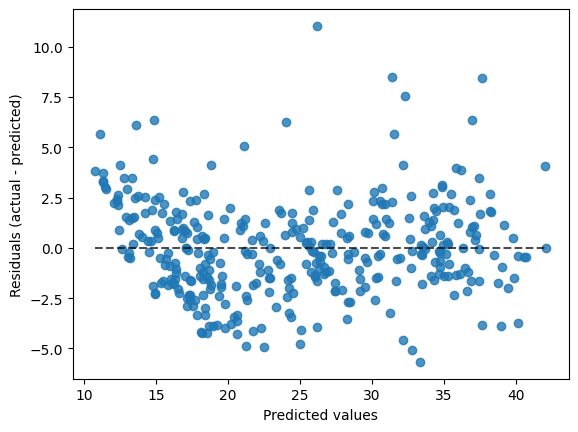

In [79]:
y_pred = lr.predict(X)
display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
display.plot()

These do not look randomly distributed. Let's try to understand which are the features figuring most prominently in this regression (i.e. have the highest coefficients):

In [81]:
import statsmodels.api as sm

def ols(X_df, y_df):
  X_wc = X_df.copy()
  X_wc = sm.add_constant(X_wc)
  reg_model=sm.OLS(y_df, X_wc)
  return reg_model.fit()

print(ols(X, y).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     109.8
Date:                Thu, 18 Apr 2024   Prob (F-statistic):          4.24e-157
Time:                        01:10:13   Log-Likelihood:                -814.47
No. Observations:                 357   AIC:                             1701.
Df Residuals:                     321   BIC:                             1841.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           24.6964      0.132    186.770   

As one might expect, features related to income and wage data have a huge impact on the regression.

## b. Controlling for income data

It's clear from our previous analysis that wage data has a huge impact on the regression prediction. Since we are interested in teasing out the features of urban design that can lead to better health outcomes, we wish to control for this income data. After trying several different models, the following nonlinear prediction function is what we landed on:

$$
\begin{align*}
LPA_{pred} &= \beta_0 + \beta_1 *\mathtt{Income} + \beta_2 *\mathtt{R\_HiWageWk} + \beta_3 *\mathtt{R\_MedWageWk}\\ &+ \beta_4 *\mathtt{R\_PCTLOWWAGE} + \beta_5 \left(*\dfrac{\mathtt{Income}}{\mathtt{R\_PCTLOWWAGE}}\right) + \beta_6 \left(\dfrac{\mathtt{Income}}{\mathtt{R\_PCTLOWWAGE}}\right)^2
\end{align*}
$$

as a preliminary prediction function.

In [110]:
wage_features = ['Income', 'R_HiWageWk', 'R_MedWageWk', 'R_PCTLOWWAGE']

df_min = StandardScaler().set_output(transform="pandas").fit_transform(df.copy()[wage_features])
df_min['interaction'] =  df['Income'] / df['R_PCTLOWWAGE']

pos_power_features = ['interaction']
neg_power_features = []

def df_power(dataframe, integers, pos, neg):
  new_df = dataframe.copy()
  for i in integers:
    if i > 0:
      for feature in pos:
        new_df[feature + '^' + str(i)] = new_df[feature]**i
    if i < 0:
      for feature in neg:
        new_df[feature + '^' + str(i)] = new_df[feature]**i
  return StandardScaler().set_output(transform="pandas").fit_transform(new_df)

df_min = (df_power(df_min, [-3,-2, -1,2,3], pos_power_features, neg_power_features))
df_min.drop(columns=['interaction^3'], inplace=True)
df_min

Income  R_HiWageWk  R_MedWageWk  R_PCTLOWWAGE  interaction  \
OBJECTID                                                                 
61493     1.826403   -0.597832    -0.975964     -0.337376     1.171316   
61680    -1.034901   -1.025557    -0.149533      1.526724    -1.050171   
61728    -1.160082   -0.561038     1.827996      1.023240    -1.071684   
61468    -1.175727   -1.034756     0.647381      1.675152    -1.120641   
61733     0.635072    0.225425    -1.084187     -1.636499     1.567847   
...            ...         ...          ...           ...          ...   
61416     0.117859    0.827921    -0.848064     -1.384182     0.662136   
61610    -0.718320   -0.708213    -0.306949      1.487523    -0.906848   
61674    -1.015313   -0.648423     1.414781      1.173554    -1.013881   
61737    -0.242971    0.197830    -0.985802     -1.068852     0.059731   
61480    -1.272998   -0.533443     1.218012      1.575767    -1.157454   

          interaction^2  
OBJECTID                 
61493          0.973049  
61680         -0.756517  
61728         -0.760450  
61468         -0.768486  
61733          1.557484  
...                 ...  
61416          0.345063  
61610         -0.724035  
61674         -0.749324  
61737         -0.220056  
61480         -0.773690  

[357 rows x 6 columns]

In [95]:
print(ols(df_min, y).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     527.1
Date:                Thu, 18 Apr 2024   Prob (F-statistic):          6.77e-172
Time:                        01:22:20   Log-Likelihood:                -860.28
No. Observations:                 357   AIC:                             1735.
Df Residuals:                     350   BIC:                             1762.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            24.6964      0.144    171.539

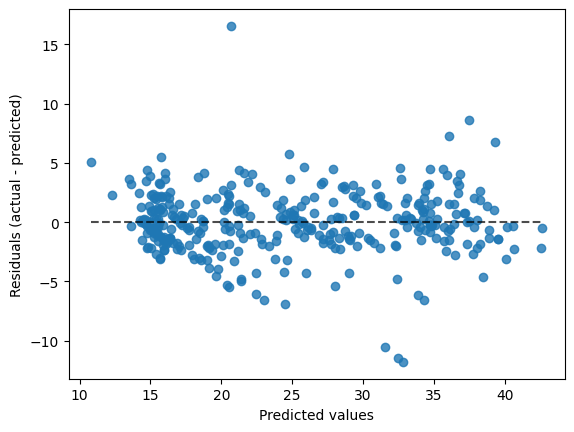

In [96]:
lr = LinearRegression()
lr.fit(df_min, y)
y_min_pred = lr.predict(df_min)
display = PredictionErrorDisplay(y_true=y, y_pred=y_min_pred)
display.plot()

The above graph looks more "random" than what we had before.

Now we focus on the residuals. Our assumption from the above is that the residuals should have no dependence on wage data.

In [99]:
y_new = y - y_min_pred
y_new

OBJECTID
61493    3.208784
61680   -0.296561
61728    0.784524
61468    0.043060
61733   -0.731955
           ...   
61416   -2.370466
61610    0.340566
61674    1.521129
61737   -3.834614
61480   -2.219504
Name: LPA, Length: 357, dtype: float64

In [101]:
print(ols(df_min, y_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                 1.024e-14
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               1.00
Time:                        01:37:20   Log-Likelihood:                -860.28
No. Observations:                 357   AIC:                             1735.
Df Residuals:                     350   BIC:                             1762.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.748e-15      0.144   1.91e-14

The horrific results seen above confirm our assumption.

Before moving to the next subsection, let's add the other features back in one by one into our wage data based regression to see how they affect the scores:

In [97]:
results_min = pd.DataFrame(data=0.0, index=list(features_of_interest), columns=["rsquared", "rsquared_adj"])
for feature in list(results_min.index):
  if feature in wage_features:
    continue
  X_big = df_min.join(other=df[feature], on="OBJECTID", how='left', validate='1:1')
  result = ols(X_big, y)
  results_min.loc[feature].rsquared = result.rsquared
  results_min.loc[feature].rsquared_adj = result.rsquared_adj

results_min

rsquared  rsquared_adj
D1C8_SVC      0.902397      0.900439
Pct_AO1       0.900731      0.898740
D3BMM4        0.901016      0.899030
D4E           0.901182      0.899200
D2A_WRKEMP    0.900693      0.898701
D2C_TRIPEQ    0.900388      0.898390
R_PCTLOWWAGE  0.000000      0.000000
D3BPO3        0.900431      0.898434
D5CR          0.907245      0.905385
P_WrkAge      0.901171      0.899189
D1A           0.904328      0.902410
Ac_Land       0.902839      0.900890
D3BMM3        0.901072      0.899088
D4D           0.906698      0.904827
D3A           0.900399      0.898401
Pct_AO2p      0.905869      0.903981
D5DR          0.914298      0.912579
D2A_EPHHM     0.900985      0.898999
R_MedWageWk   0.000000      0.000000
D3APO         0.900621      0.898627
D5CE          0.902076      0.900112
D2R_WRKEMP    0.900514      0.898518
D2B_E5MIX     0.902590      0.900637
D2R_JOBPOP    0.900578      0.898584
D3AMM         0.901694      0.899722
TotPop        0.901713      0.899742
R_HiWageWk    0.000000      0.000000
D3BPO4        0.900484      0.898488
Income        0.000000      0.000000
D2A_JPHH      0.901551      0.899577
D2B_E8MIX     0.901007      0.899022
E5_Off        0.900421      0.898423
E8_Hlth       0.900654      0.898661
D1C8_HLTH     0.903567      0.901633
D4A           0.901427      0.899450

The above gives us a sense of what we should expect to be the most impactful features going forward.

## c. Feature selection, again

Let's do a first pass OLS regression to see how good the linear model is at predicting the residuals

In [124]:
X_for_no_income = StandardScaler().set_output(transform="pandas").fit_transform(df.copy()[list(features_of_interest)])
print(ols(X_for_no_income, y_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     4.473
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           1.75e-12
Time:                        02:13:28   Log-Likelihood:                -796.85
No. Observations:                 357   AIC:                             1658.
Df Residuals:                     325   BIC:                             1782.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.702e-15      0.125   2.96e-14      1.0

It is not as good as we might have liked, but it is not altogether useless. We are being penalized for having a lot of features (possibly a sign of overfitting?), so we want to get rid of a few of them.

Let's see how well the remaining features are correlated with our outcome:

In [128]:
features_of_interest = features_of_interest.difference(wage_features)

outcome_corrs = df[list(features_of_interest) + [HEALTH_OUTCOME]].corr().abs().loc[HEALTH_OUTCOME]

outcome_corrs

D1C8_SVC      0.208553
Pct_AO1       0.229936
D3BMM4        0.252969
Pct_AO2p      0.145081
D5DR          0.631996
D2A_EPHHM     0.344944
D4E           0.153173
D3APO         0.019755
D2A_WRKEMP    0.289619
D5CE          0.076174
D2R_WRKEMP    0.244009
D2B_E5MIX     0.183973
D2C_TRIPEQ    0.311734
D2R_JOBPOP    0.314437
D3AMM         0.235534
TotPop        0.051862
D3BPO3        0.000949
D3BPO4        0.107777
D3A           0.163968
D5CR          0.542392
P_WrkAge      0.402737
D1A           0.266524
D2A_JPHH      0.116446
Ac_Land       0.083625
D2B_E8MIX     0.176980
D3BMM3        0.175999
E5_Off        0.122830
E8_Hlth       0.027394
D1C8_HLTH     0.079737
D4A           0.026902
D4D           0.272009
LPA           1.000000
Name: LPA, dtype: float64

It looks like several features are poorly correlated with the outcome. We drop some of them based on a threshold:

In [161]:
OUTCOME_CORR_THRESHOLD = 0.05

features_of_interest = features_of_interest.difference(outcome_corrs[outcome_corrs < OUTCOME_CORR_THRESHOLD].index)

features_of_interest

{'Ac_Land',
 'D1A',
 'D1C8_HLTH',
 'D1C8_SVC',
 'D2A_EPHHM',
 'D2A_JPHH',
 'D2A_WRKEMP',
 'D2B_E5MIX',
 'D2B_E8MIX',
 'D2C_TRIPEQ',
 'D2R_JOBPOP',
 'D2R_WRKEMP',
 'D3A',
 'D3AMM',
 'D3BMM3',
 'D3BMM4',
 'D3BPO4',
 'D4D',
 'D4E',
 'D5CE',
 'D5CR',
 'D5DR',
 'E5_Off',
 'P_WrkAge',
 'Pct_AO1',
 'Pct_AO2p',
 'TotPop'}

In [ ]:
temppp = list(features_of_interest)

Since we want to make recommendations to the stakeholders on how to improve health outcomes with the land and the people they already have, we drop the features that cannot be altered:

In [164]:
features_of_interest = features_of_interest.difference(['Ac_Land', 'TotPop', 'P_WrkAge'])

X_for_no_income_2 = StandardScaler().set_output(transform="pandas").fit_transform(df.copy()[list(features_of_interest)])
print(ols(X_for_no_income_2, y_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     5.018
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           2.74e-12
Time:                        02:39:27   Log-Likelihood:                -805.03
No. Observations:                 357   AIC:                             1660.
Df Residuals:                     332   BIC:                             1757.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.748e-15      0.127   2.17e-14      1.0

Dropping a few more features that have really low coefficients:

In [177]:
features_of_interest = features_of_interest.difference(['D3AMM', 'D3BMM3', 'D1C8_SVC', 'D2A_WRKEMP',
                                                        'D2C_TRIPEQ', 'D1C8_HLTH', 'D3BPO4', 'D2R_JOBPOP', 'D2B_E8MIX', 'D2A_EPHHM',
                                                        'D3BMM4', 'D2B_E5MIX'])

X_for_no_income_3 = StandardScaler().set_output(transform="pandas").fit_transform(df.copy()[list(features_of_interest)])
print(ols(X_for_no_income_3, y_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     9.912
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           1.09e-16
Time:                        03:00:28   Log-Likelihood:                -807.27
No. Observations:                 357   AIC:                             1641.
Df Residuals:                     344   BIC:                             1691.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.748e-15      0.125    2.2e-14      1.0

Let's study the remaining features above in greater detail, and also run a linear regression to see how well they individually predict the residuals:

<Figure size 640x480 with 0 Axes>

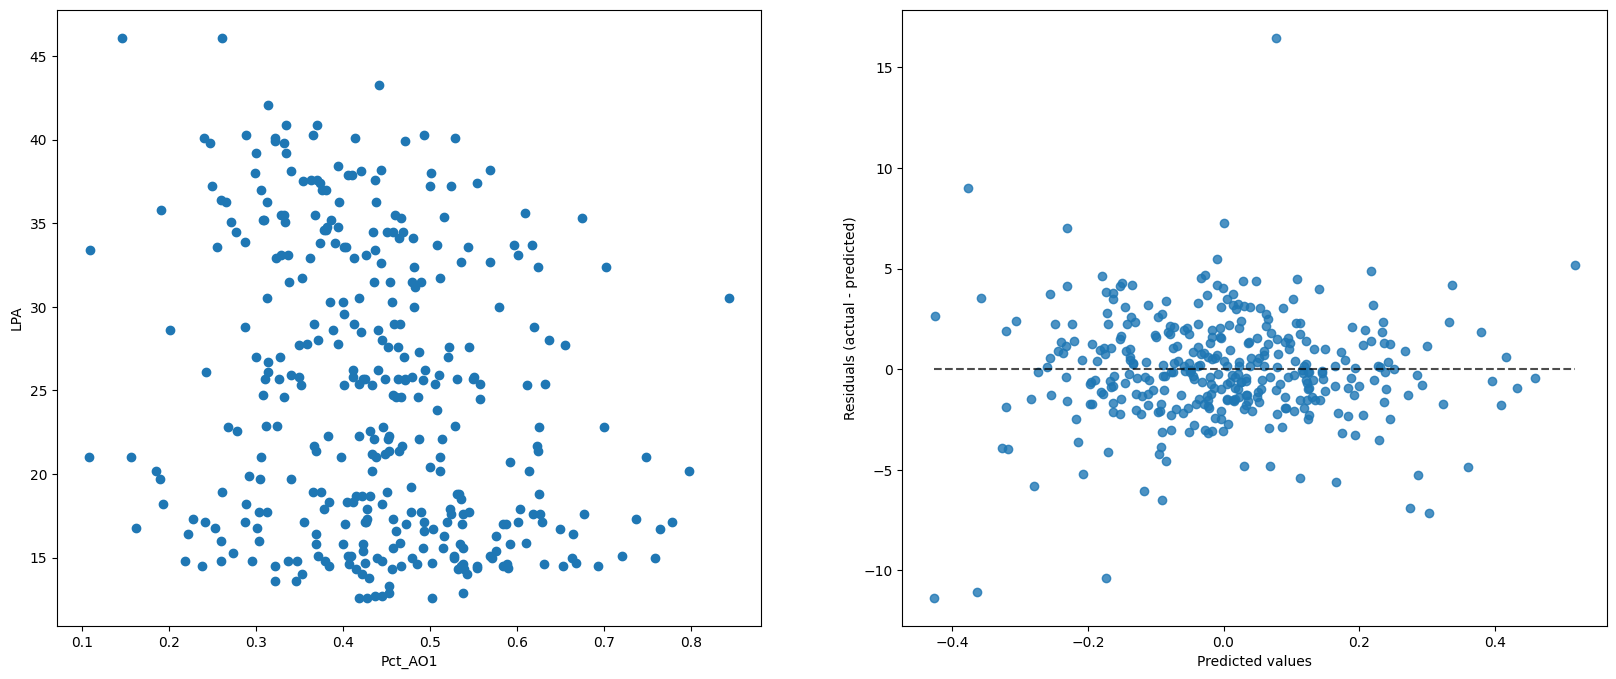

<Figure size 640x480 with 0 Axes>

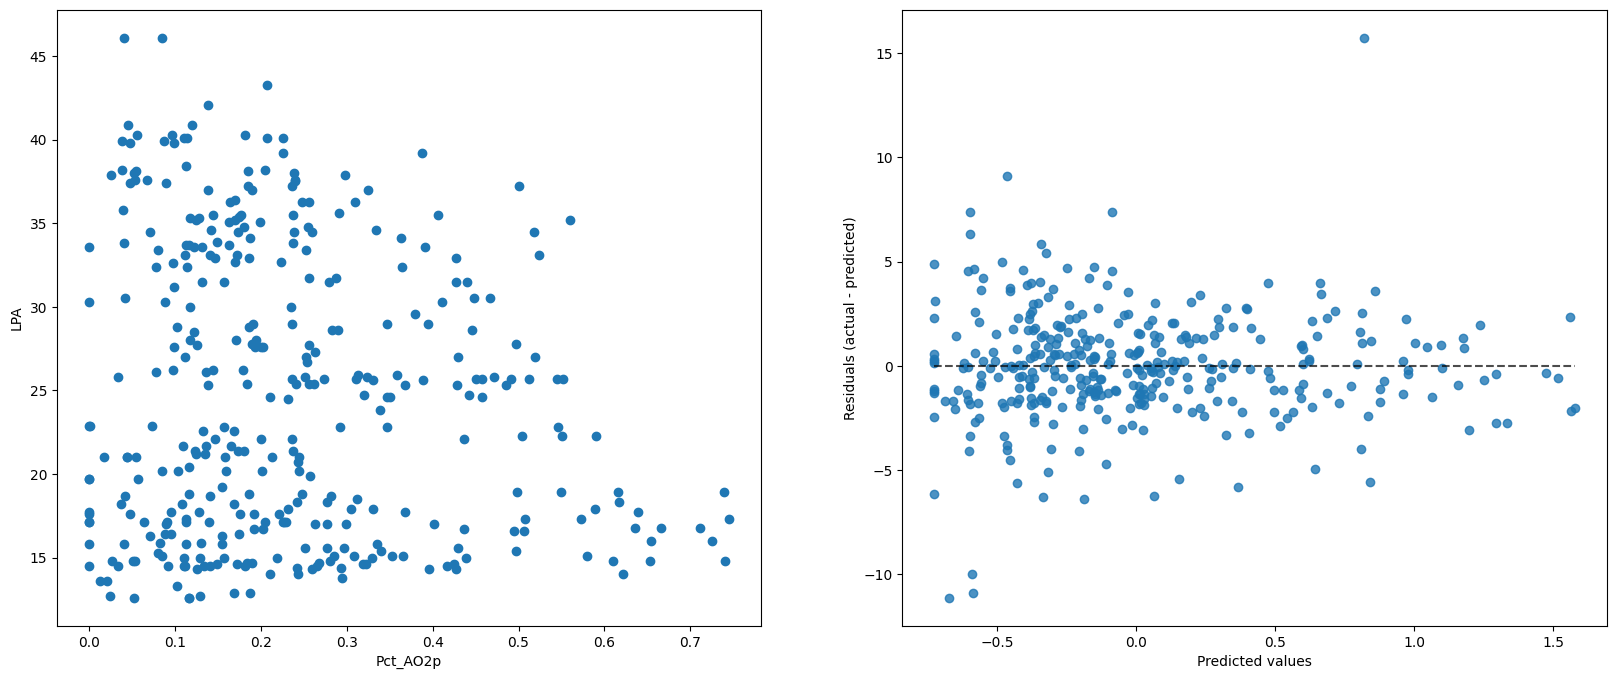

<Figure size 640x480 with 0 Axes>

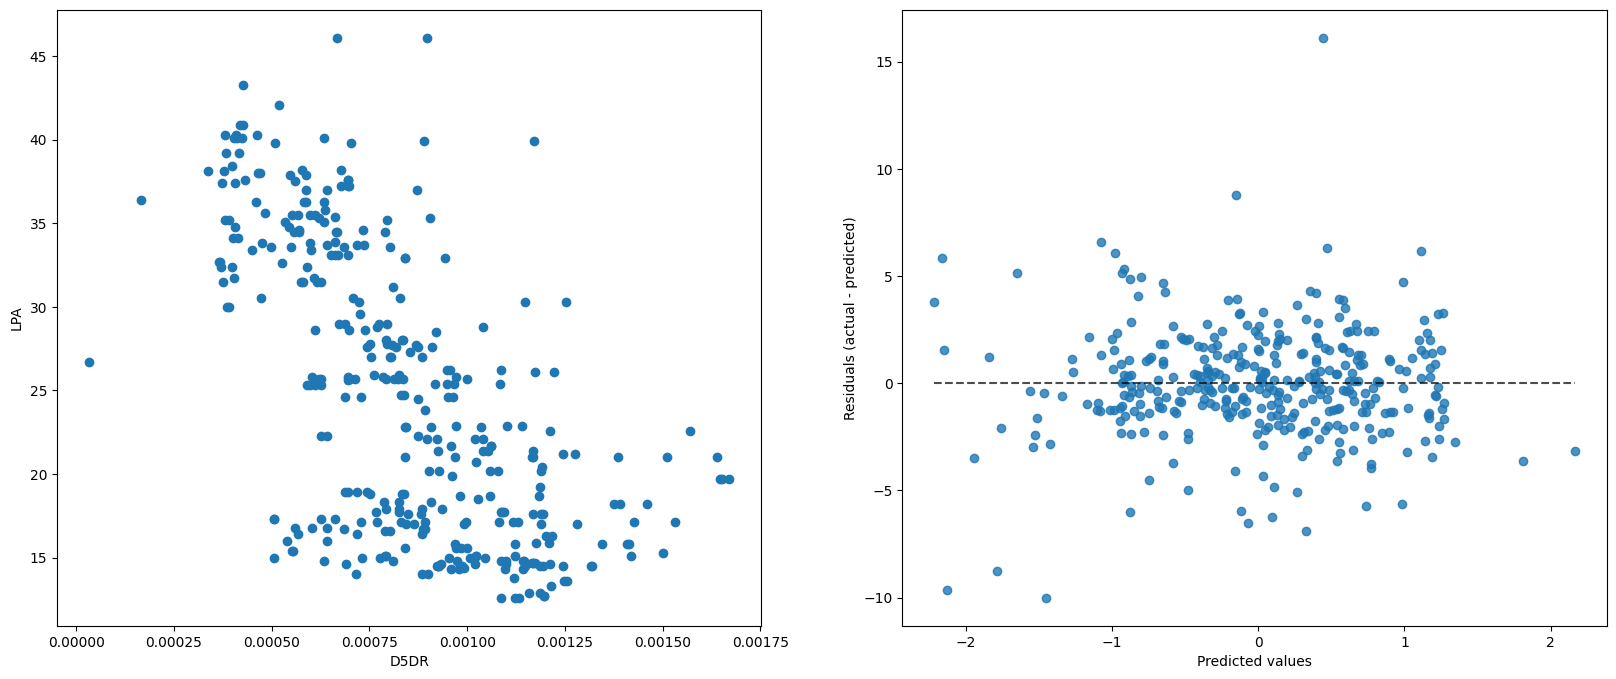

<Figure size 640x480 with 0 Axes>

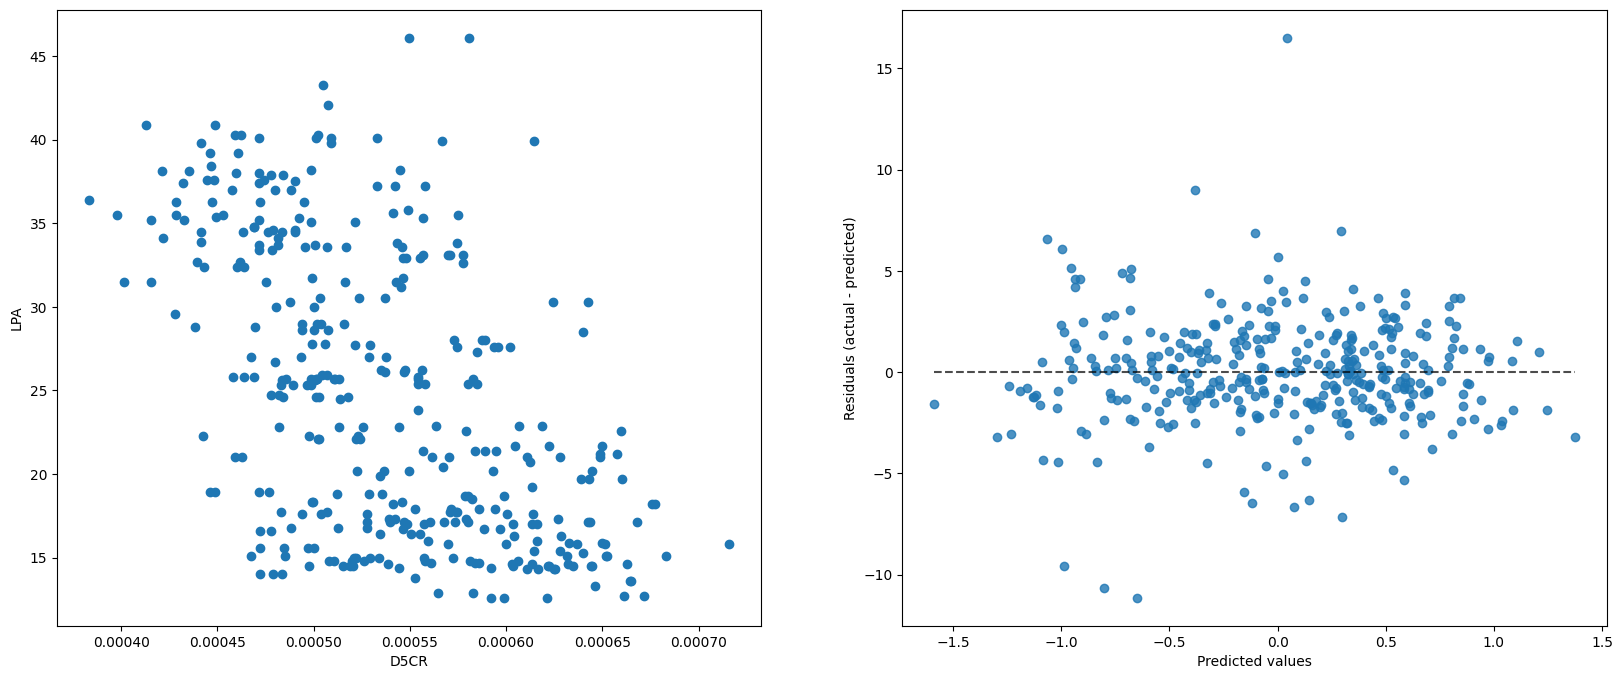

<Figure size 640x480 with 0 Axes>

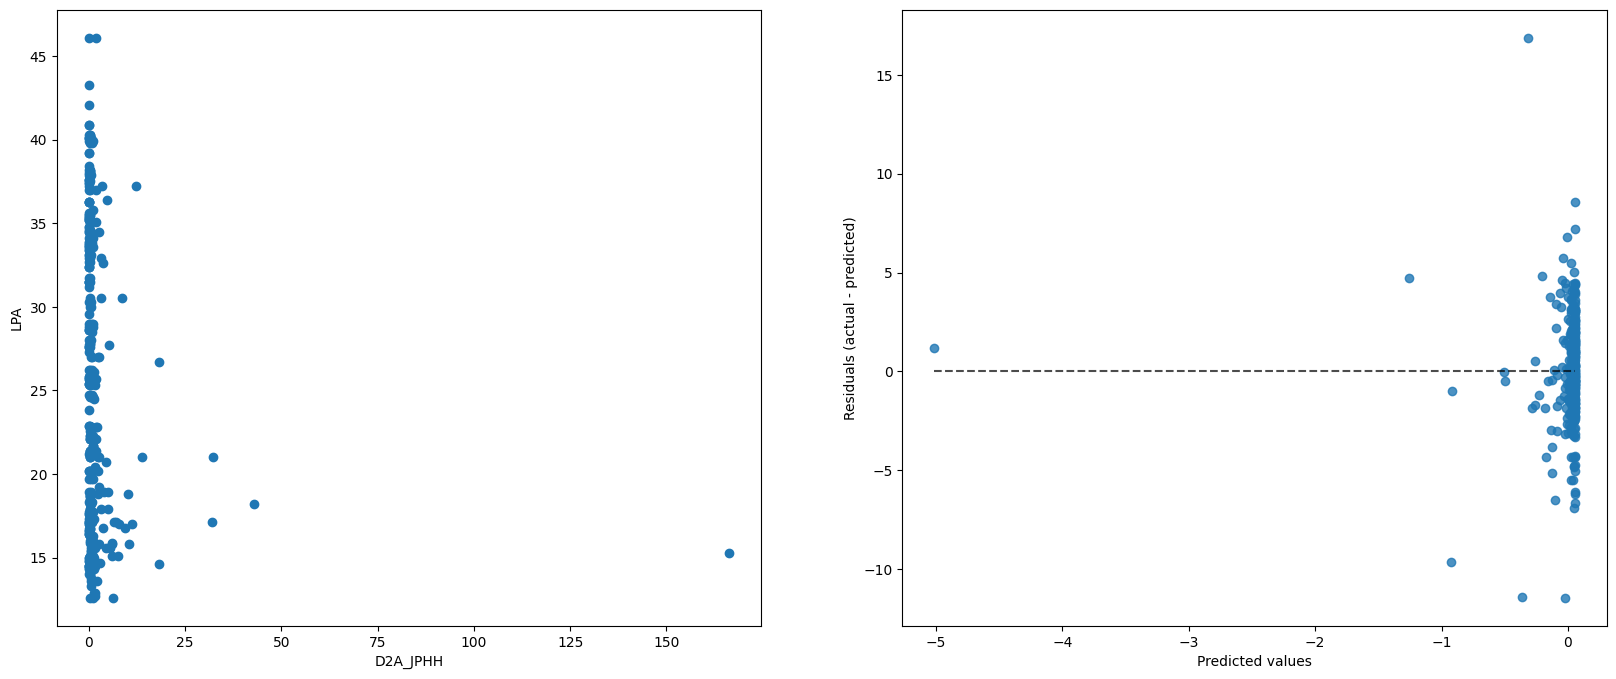

<Figure size 640x480 with 0 Axes>

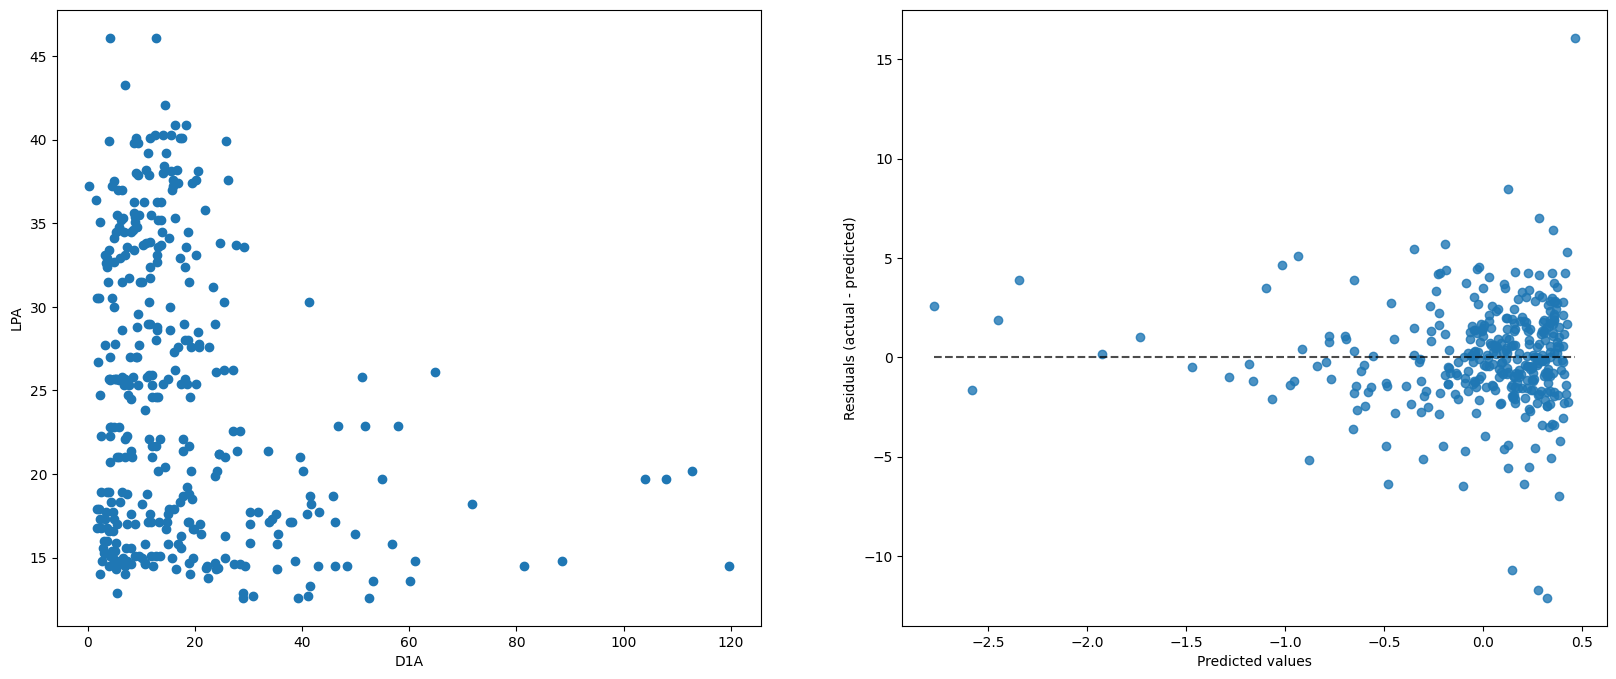

<Figure size 640x480 with 0 Axes>

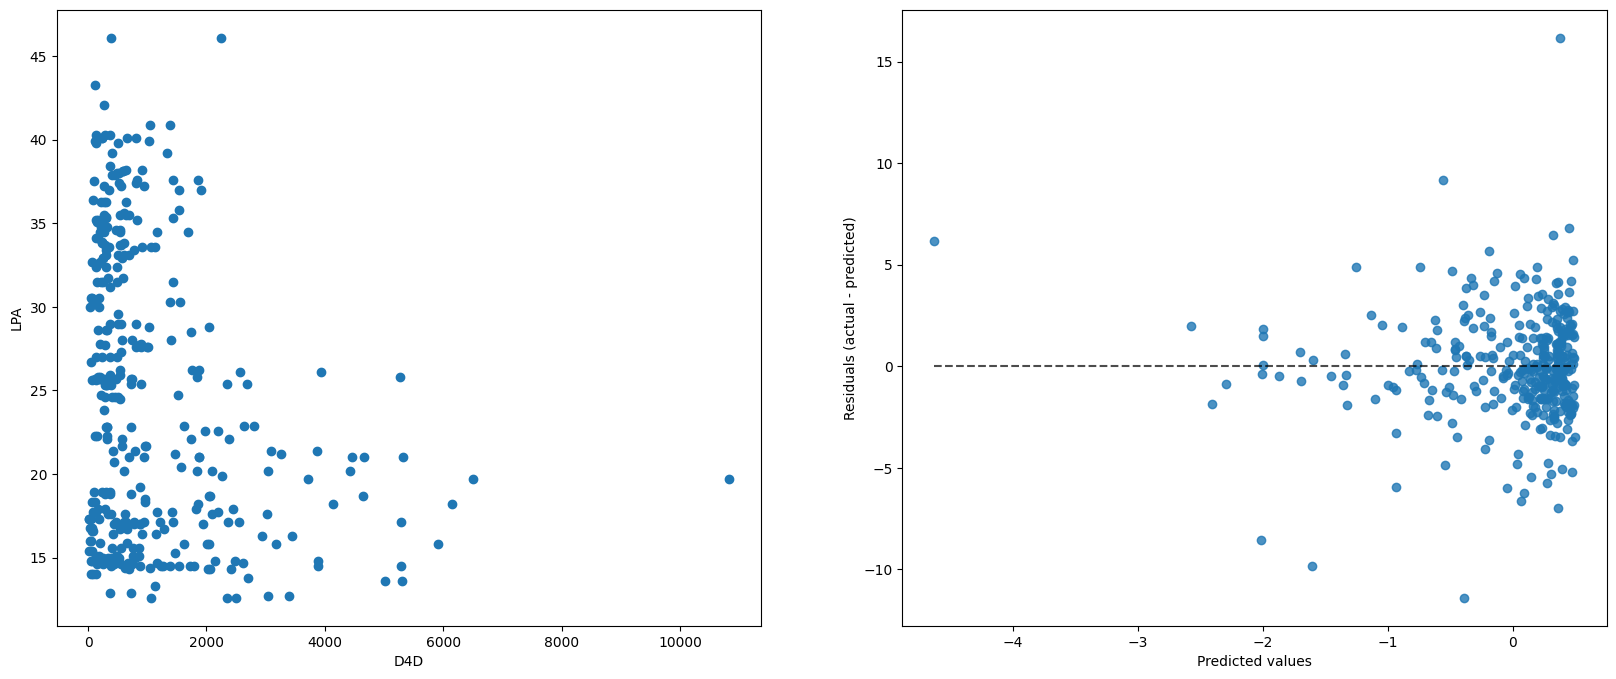

<Figure size 640x480 with 0 Axes>

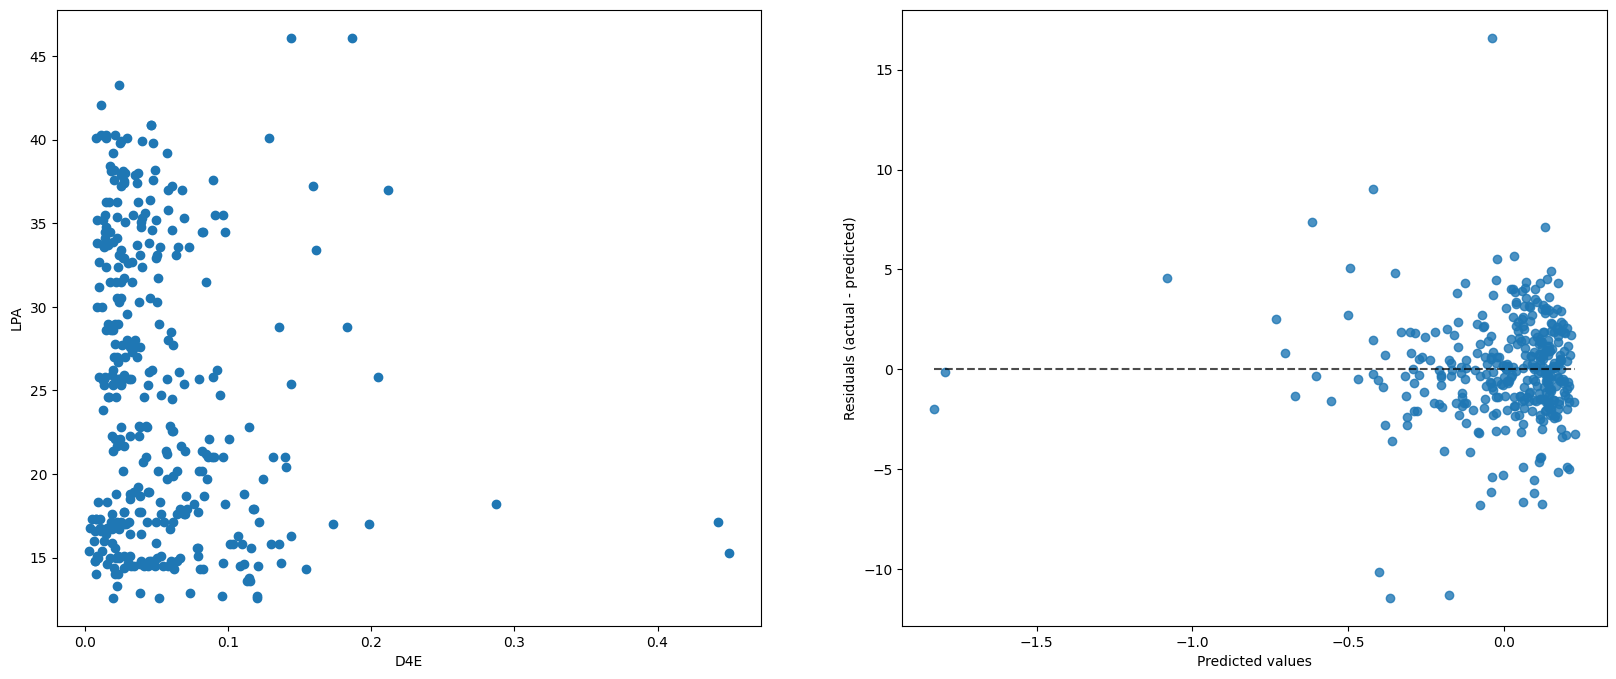

<Figure size 640x480 with 0 Axes>

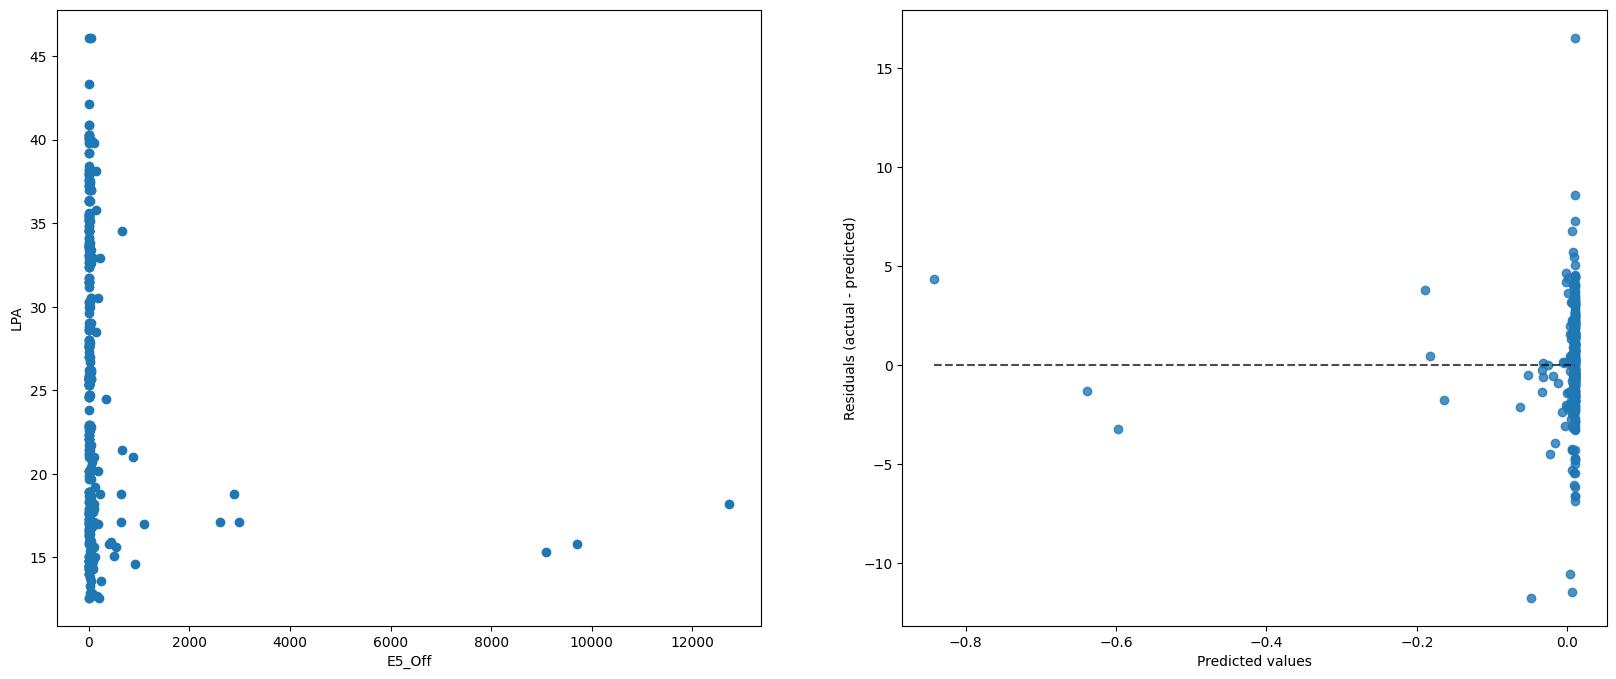

<Figure size 640x480 with 0 Axes>

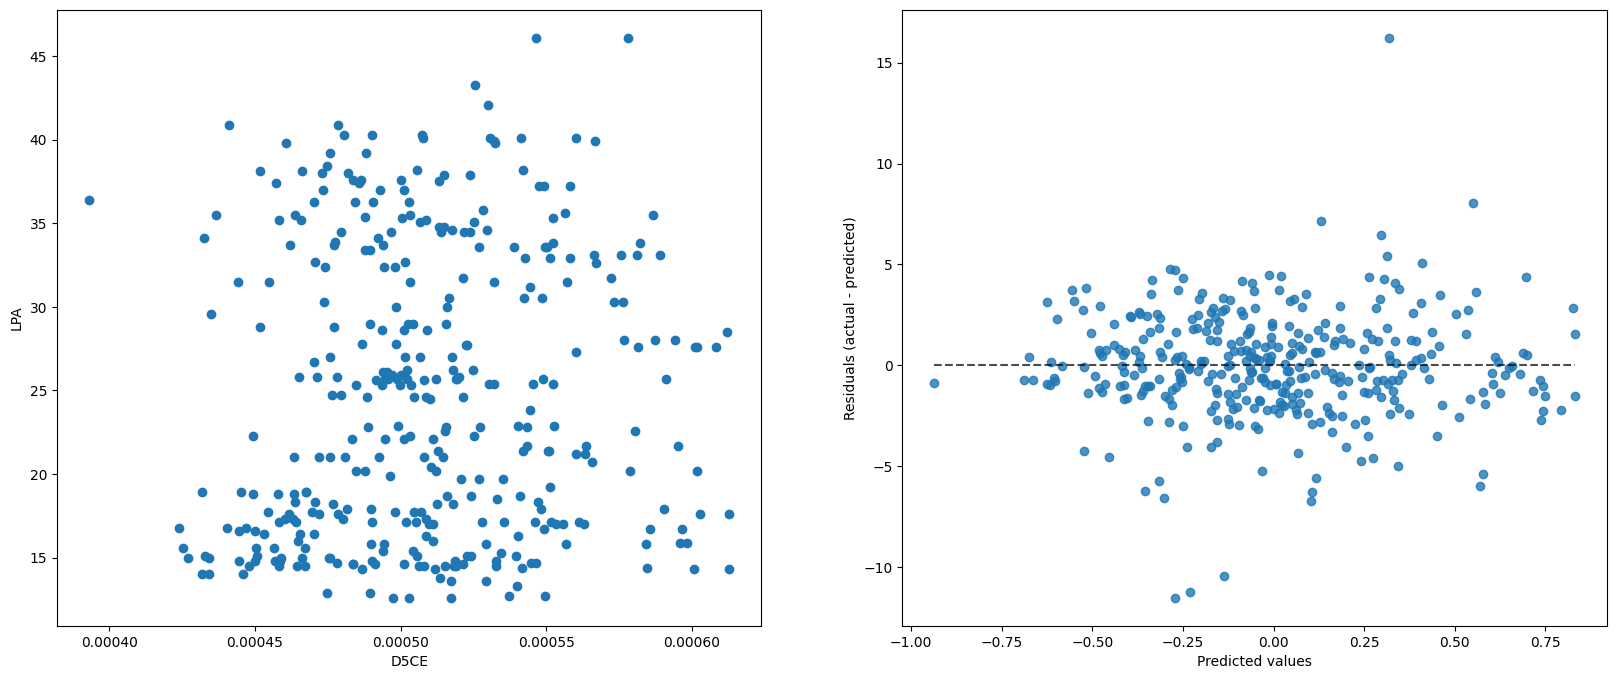

<Figure size 640x480 with 0 Axes>

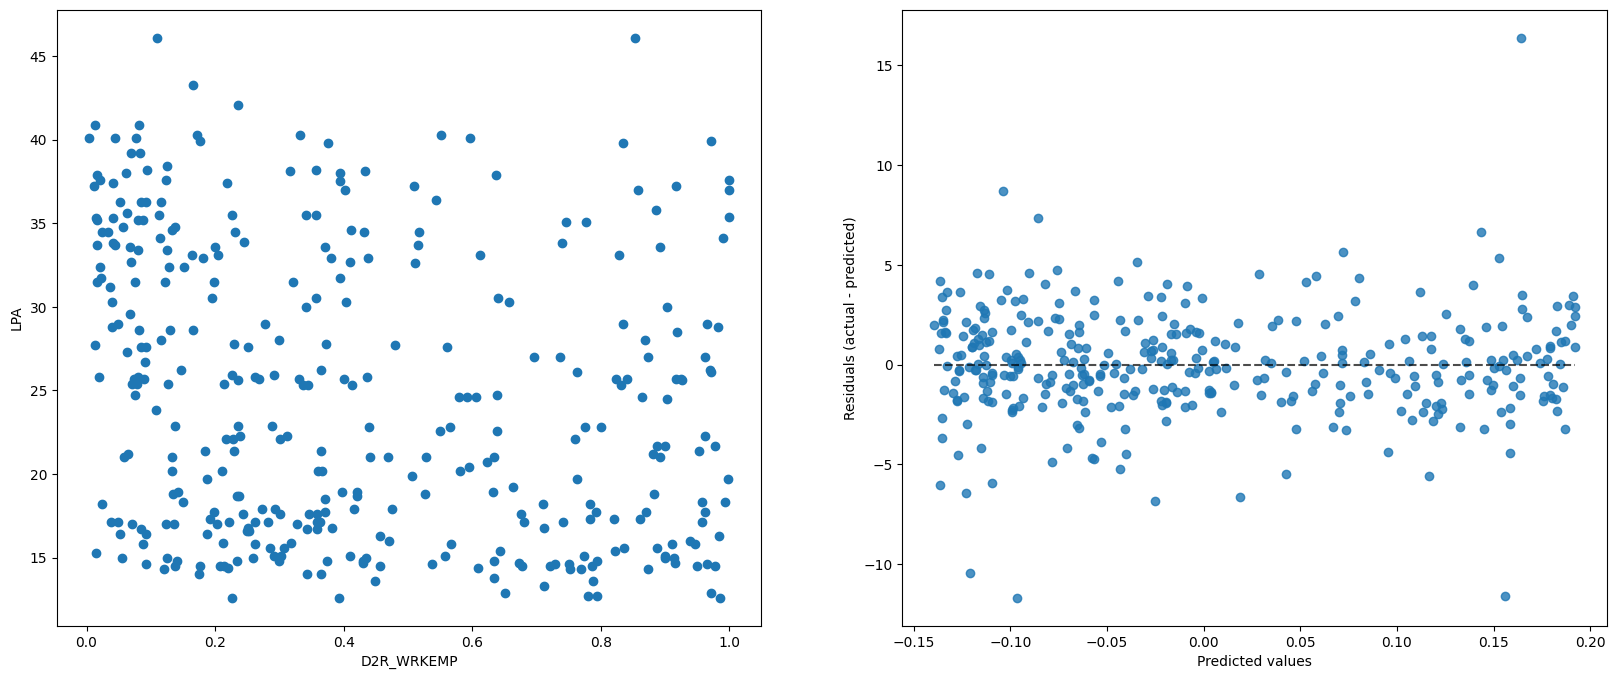

<Figure size 640x480 with 0 Axes>

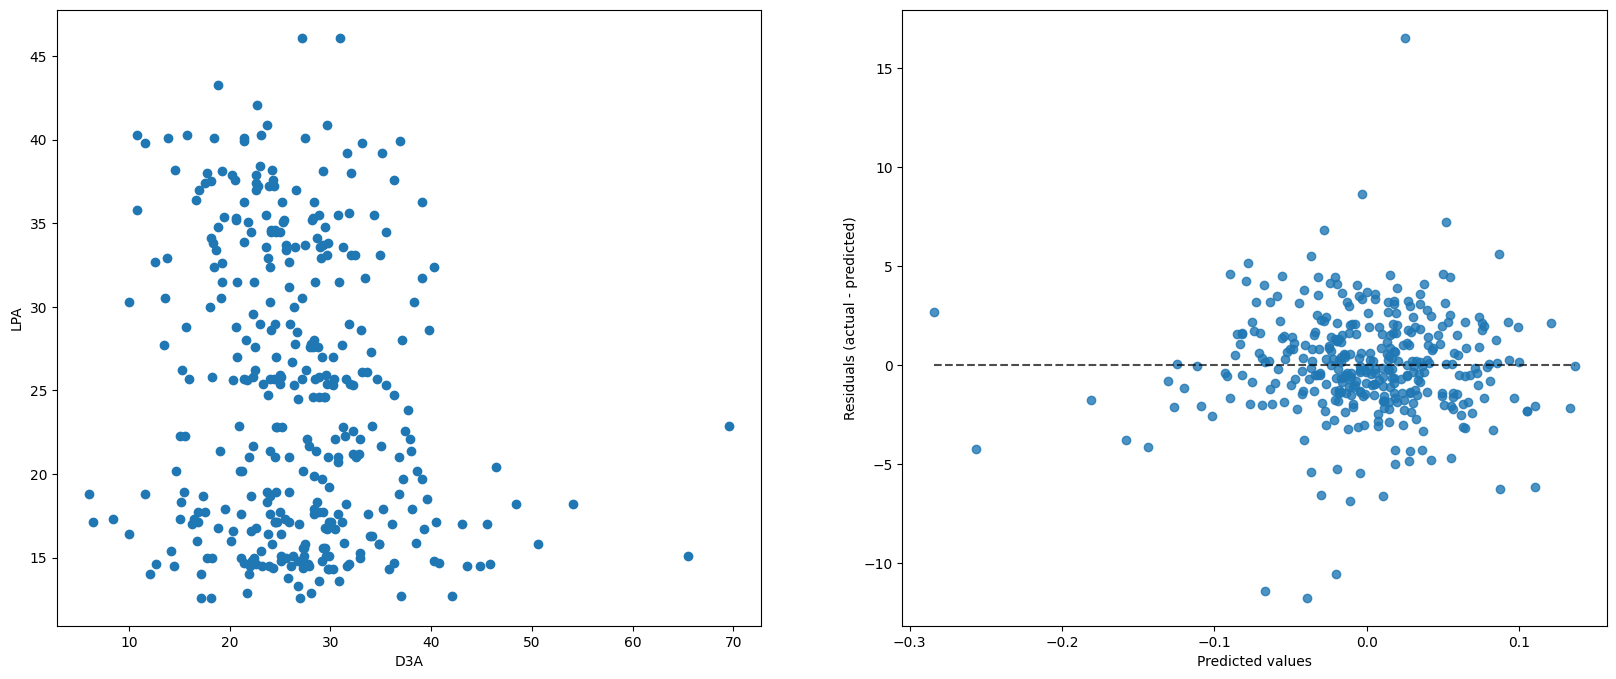

In [179]:
scores = pd.DataFrame(data=0.0, index=list(features_of_interest), columns=["score"])

for feature in features_of_interest:
  lr = LinearRegression()
  X_single = pd.DataFrame(data=df.copy()[feature])
  lr.fit(X=X_single, y=y_new)
  scores.loc[feature].score = lr.score(X_single, y_new)
  y_pred_sing = lr.predict(X_single)

  plt.clf()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
  #plt.figure()
  plt.subplot(121)
  plt.scatter(x=X_single, y=y)
  plt.xlabel(feature)
  plt.ylabel(HEALTH_OUTCOME)

  plt.subplot(122)
  display = PredictionErrorDisplay(y_true=y_new, y_pred=y_pred_sing)
  display.plot(ax=ax2)
  plt.show()

In [180]:
scores

score
Pct_AO1     0.003474
Pct_AO2p    0.035493
D5DR        0.079778
D5CR        0.045438
D2A_JPHH    0.011717
D1A         0.029087
D4D         0.051807
D4E         0.007380
E5_Off      0.000623
D5CE        0.015551
D2R_WRKEMP  0.001460
D3A         0.000396

## b. Studying dependence of $R^2$ on features

For each feature we haven't included, explore how its inclusion would change the score:

In [ ]:
# results = pd.DataFrame(data=0.0, index=features_of_interest, columns=["rsquared", "rsquared_adj"])
# for feature in list(results.index):
#   if feature in final_features:
#     continue
#   X_big = df.copy()[final_features + [feature]]
#   result = ols(X_big, y)
#   results.loc[feature].rsquared = result.rsquared
#   results.loc[feature].rsquared_adj = result.rsquared_adj

# results

For each feature we have included, explore how its exclusion would change the score:

In [ ]:
# results2 = pd.DataFrame(data=0.0, index=final_features, columns=["rsquared", "rsquared_adj"])
# for feature in final_features:
#   X_big = df.copy()[final_features].drop(columns=[feature])
#   result = ols(X_big, y)
#   results2.loc[feature].rsquared = result.rsquared
#   results2.loc[feature].rsquared_adj = result.rsquared_adj

# results2

## d. Testing the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=SEED)

def get_min_features(dataset):
  df_min = StandardScaler().set_output(transform="pandas").fit_transform(dataset.copy()[min_features])
  df_min['interaction'] =  dataset['Income'] / dataset['R_PCTLOWWAGE']

  pos_power_features = ['interaction']
  neg_power_features = []

  df_min = (df_power(df_min, [-3,-2, -1,2,3]))
  df_min.drop(columns=['interaction^3'], inplace=True)
  return df_min


X_train = get_min_features(X_train)
X_test = get_min_features(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8366746205877658

In [ ]:
#scores = cross_val_score(lr, X_train, y_train, cv=kf)